In [1]:
import pandas as pd
import os.path as osp
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from scipy.sparse.csgraph import shortest_path

from torch_geometric.utils import (negative_sampling, to_dense_adj, dense_to_sparse, 
                                   from_scipy_sparse_matrix, remove_self_loops)
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GATv2Conv, ResGatedGraphConv, ClusterGCNConv
from torch_geometric.data import Data, InMemoryDataset, DataLoader, Data, download_url
from torch_geometric.utils import (negative_sampling, add_self_loops,sort_edge_index,
                                   train_test_split_edges, k_hop_subgraph,
                                   to_scipy_sparse_matrix, to_networkx,
                                  is_undirected, to_undirected)


from typing import Optional, Callable

/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)

# Data Loading

In [3]:
class MersInfection(InMemoryDataset):

    """Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    """

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        

    @property
    def raw_file_names(self) -> str:
        return 'Mers_infection.npz'

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        pass

    def process(self):
        data = np.load(self.raw_paths[0], 'r', allow_pickle=True)
        x = torch.from_numpy(data['x']).to(torch.float)
        print('processing')
        
        edge_index = torch.from_numpy(data['edge_index']).to(torch.long)
        edge_index = edge_index.t().contiguous()
        edge_index = torch.transpose(edge_index, 0, 1)
        
        data = Data(x=x, edge_index=edge_index)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

In [4]:
# load dataset

dataset = MersInfection(root='data/MersInfection')
dataset.num_features

29

In [5]:
data = dataset[0]
print(data)

Data(x=[186, 29], edge_index=[2, 366])


In [6]:
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)

print(data)

Data(x=[186, 29], val_pos_edge_index=[2, 9], test_pos_edge_index=[2, 18], train_pos_edge_index=[2, 312], train_neg_adj_mask=[186, 186], val_neg_edge_index=[2, 9], test_neg_edge_index=[2, 18])


/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


# Model

In [7]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Net, self).__init__()
        self.conv1 = GCNConv(in_channels, 256)
        self.conv2 = GCNConv(256, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        return self.conv2(x, edge_index)

    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        source = z[edge_index[0]]
        target = z[edge_index[1]]
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (torch.sigmoid(prob_adj) > 0.9).nonzero(as_tuple=False).t()

In [8]:
def get_link_labels(pos_edge_index, neg_edge_index):
    num_links = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(num_links, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train(data):
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1))

    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test(data):
    model.eval()

    z = model.encode(data.x, data.train_pos_edge_index)

    results = []
    for prefix in ['val', 'test']:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']
        link_logits = model.decode(z, pos_edge_index, neg_edge_index)
        link_probs = link_logits.sigmoid()
        link_labels = get_link_labels(pos_edge_index, neg_edge_index)
        results.append(roc_auc_score(link_labels.cpu(), link_probs.cpu()))
    return results

# Training

In [9]:
# del model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, 64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005)

In [10]:
epochs = 1500

list_val_auc = []
best_val_auc1 = best_val_auc = test_auc = 0
for epoch in range(1, epochs+1):
    loss = train(data)
    val_auc, temp_test_auc = test(data)
    list_val_auc.append(val_auc)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        test_auc = temp_test_auc
    if epoch > 300 and val_auc > best_val_auc1:
        best_val_auc1 = val_auc
        torch.save(model.state_dict(), 'infection_best_model.pt')
    print('Epoch: %03d, Loss: %.4f, Val: %.4f, Test: %.4f'%(epoch, loss, val_auc, test_auc))
        
print('Best Val: %.4f, Best Val>300: %.4f'%(best_val_auc,best_val_auc1))

Epoch: 001, Loss: 0.6551, Val: 0.9506, Test: 0.9444
Epoch: 002, Loss: 0.6013, Val: 0.9506, Test: 0.9444
Epoch: 003, Loss: 0.6143, Val: 0.9383, Test: 0.9444
Epoch: 004, Loss: 0.5958, Val: 0.9136, Test: 0.9444
Epoch: 005, Loss: 0.5688, Val: 0.9136, Test: 0.9444
Epoch: 006, Loss: 0.5592, Val: 0.9259, Test: 0.9444
Epoch: 007, Loss: 0.5402, Val: 0.9259, Test: 0.9444
Epoch: 008, Loss: 0.5271, Val: 0.9259, Test: 0.9444
Epoch: 009, Loss: 0.5076, Val: 0.9259, Test: 0.9444
Epoch: 010, Loss: 0.4817, Val: 0.9259, Test: 0.9444
Epoch: 011, Loss: 0.5021, Val: 0.9012, Test: 0.9444
Epoch: 012, Loss: 0.4573, Val: 0.8642, Test: 0.9444
Epoch: 013, Loss: 0.4809, Val: 0.8519, Test: 0.9444
Epoch: 014, Loss: 0.4626, Val: 0.8395, Test: 0.9444
Epoch: 015, Loss: 0.4766, Val: 0.8395, Test: 0.9444
Epoch: 016, Loss: 0.4542, Val: 0.8519, Test: 0.9444
Epoch: 017, Loss: 0.4365, Val: 0.8642, Test: 0.9444
Epoch: 018, Loss: 0.4238, Val: 0.8395, Test: 0.9444
Epoch: 019, Loss: 0.4337, Val: 0.8025, Test: 0.9444
Epoch: 020, 

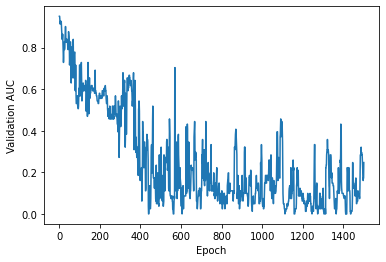

In [11]:
plt.plot(range(1, epochs+1), list_val_auc)
plt.ylabel('Validation AUC')
plt.xlabel('Epoch')
plt.show()

# Generating pred_graph

In [12]:
model.load_state_dict(torch.load('infection_best_model.pt'))
model.eval()

Net(
  (conv1): GCNConv(29, 256)
  (conv2): GCNConv(256, 64)
)

In [13]:
# load dataset

dataset1 = MersInfection(root='data/MersInfection')

In [14]:
z = model.encode(dataset1[0].x, dataset1[0].edge_index)
pred_edge_index = model.decode_all(z)
pred_edge_index.shape

torch.Size([2, 757])

In [15]:
pred_edge_index, _ = remove_self_loops(pred_edge_index)
pred_edge_index.shape

torch.Size([2, 694])

In [16]:
final_data = dataset1[0]
final_data.edge_index = pred_edge_index
final_data

Data(x=[186, 29], edge_index=[2, 694])

In [17]:
final_G = to_networkx(final_data).to_undirected()
print(nx.info(final_G))

Graph with 186 nodes and 347 edges


In [18]:
original_data = dataset1[0]
original_data

Data(x=[186, 29], edge_index=[2, 366])

In [19]:
original_G = to_networkx(original_data).to_undirected()
print(nx.info(original_G))

Graph with 186 nodes and 183 edges


In [20]:
edge_color = {}
pred_edge_list = list(final_G.edges).copy()
neg_edge_list = []

count = 0
for edge in list(original_G.edges):
    count += 1
    if edge in list(final_G.edges):
        edge_color[edge] = 'black'
        pred_edge_list.remove(edge)
    else:
        neg_edge_list.append(edge)

In [21]:
for edge in pred_edge_list:
    edge_color[edge] = 'blue'
    
for edge in neg_edge_list:
    edge_color[edge] = 'red'

In [30]:
pos = [edge for edge in list(final_G.edges) if edge_color[edge]=='black']

print(len(pos), len(neg_edge_list), len(pred_edge_list))

174 9 173


In [23]:
final_G.add_edges_from(neg_edge_list)
print(nx.info(final_G))

Graph with 186 nodes and 356 edges


In [24]:
d = dict(original_G.degree)
comm_index = [np.where(r==1)[0][0] for r in final_data.x[:,1:]]

pos = nx.spring_layout(original_G,  k=0.15, seed=4572321)
node_color = comm_index
node_size = [v * 100 for v in d.values()]

color = [edge_color[edge] for edge in list(final_G.edges)]

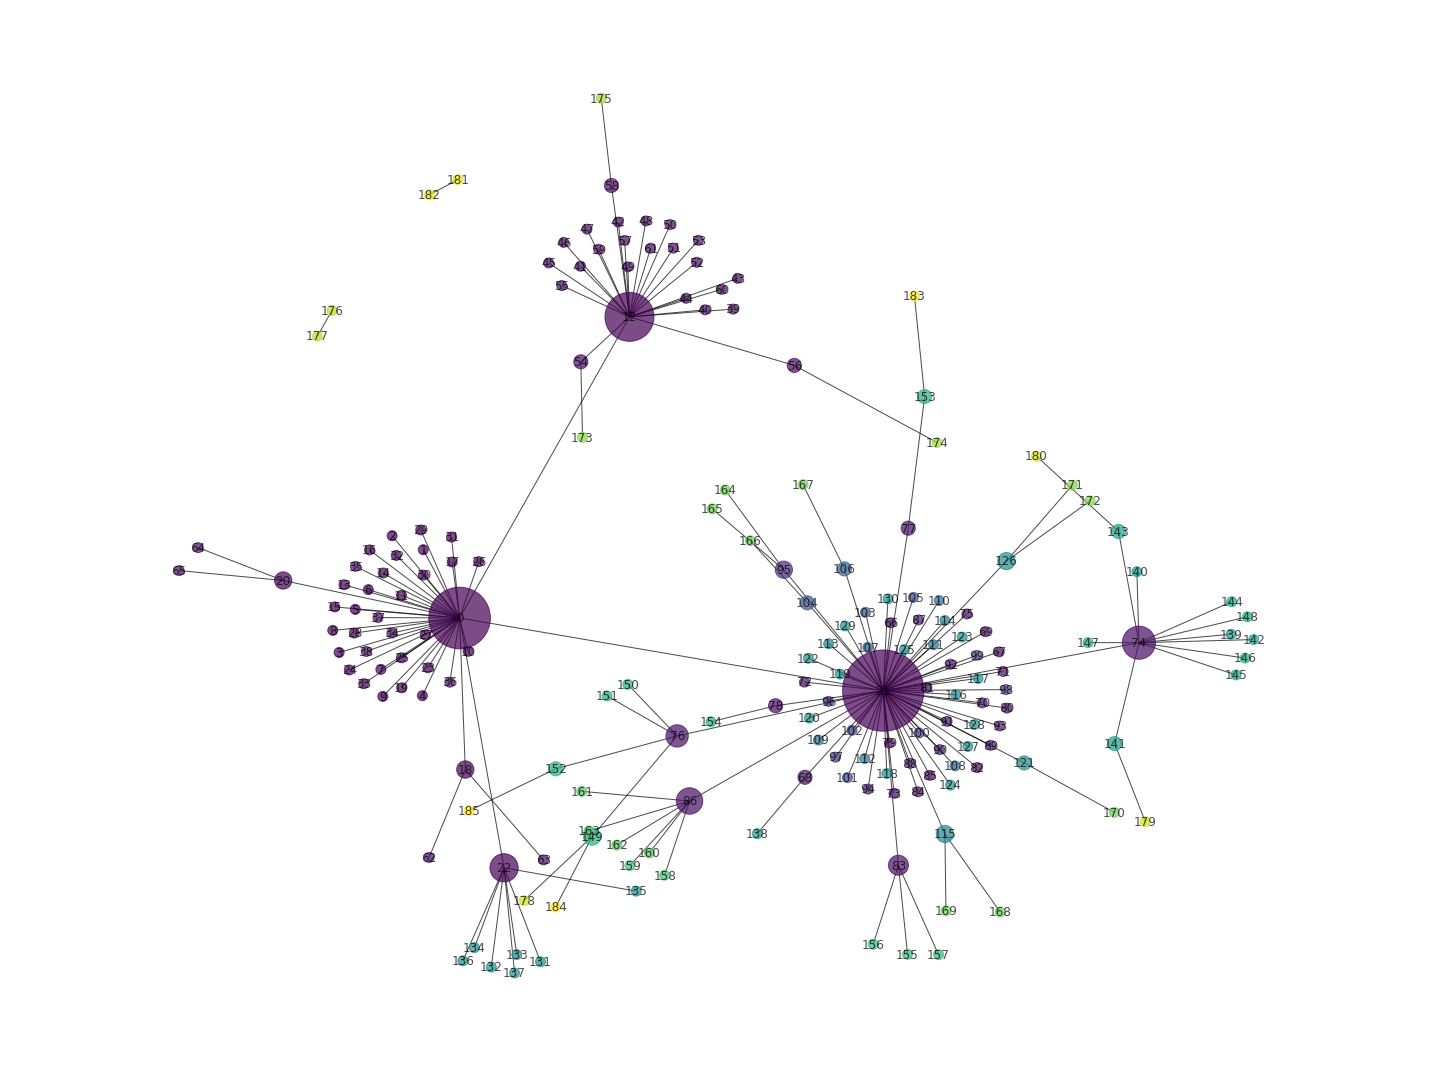

In [27]:
fig, ax = plt.subplots(figsize=(20, 15))

nx.draw_networkx(
    original_G,
    pos=pos,
    with_labels=True,
    node_color=node_color,
    node_size=node_size,
    #edge_color="gainsboro",
    alpha=0.7,
)
# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

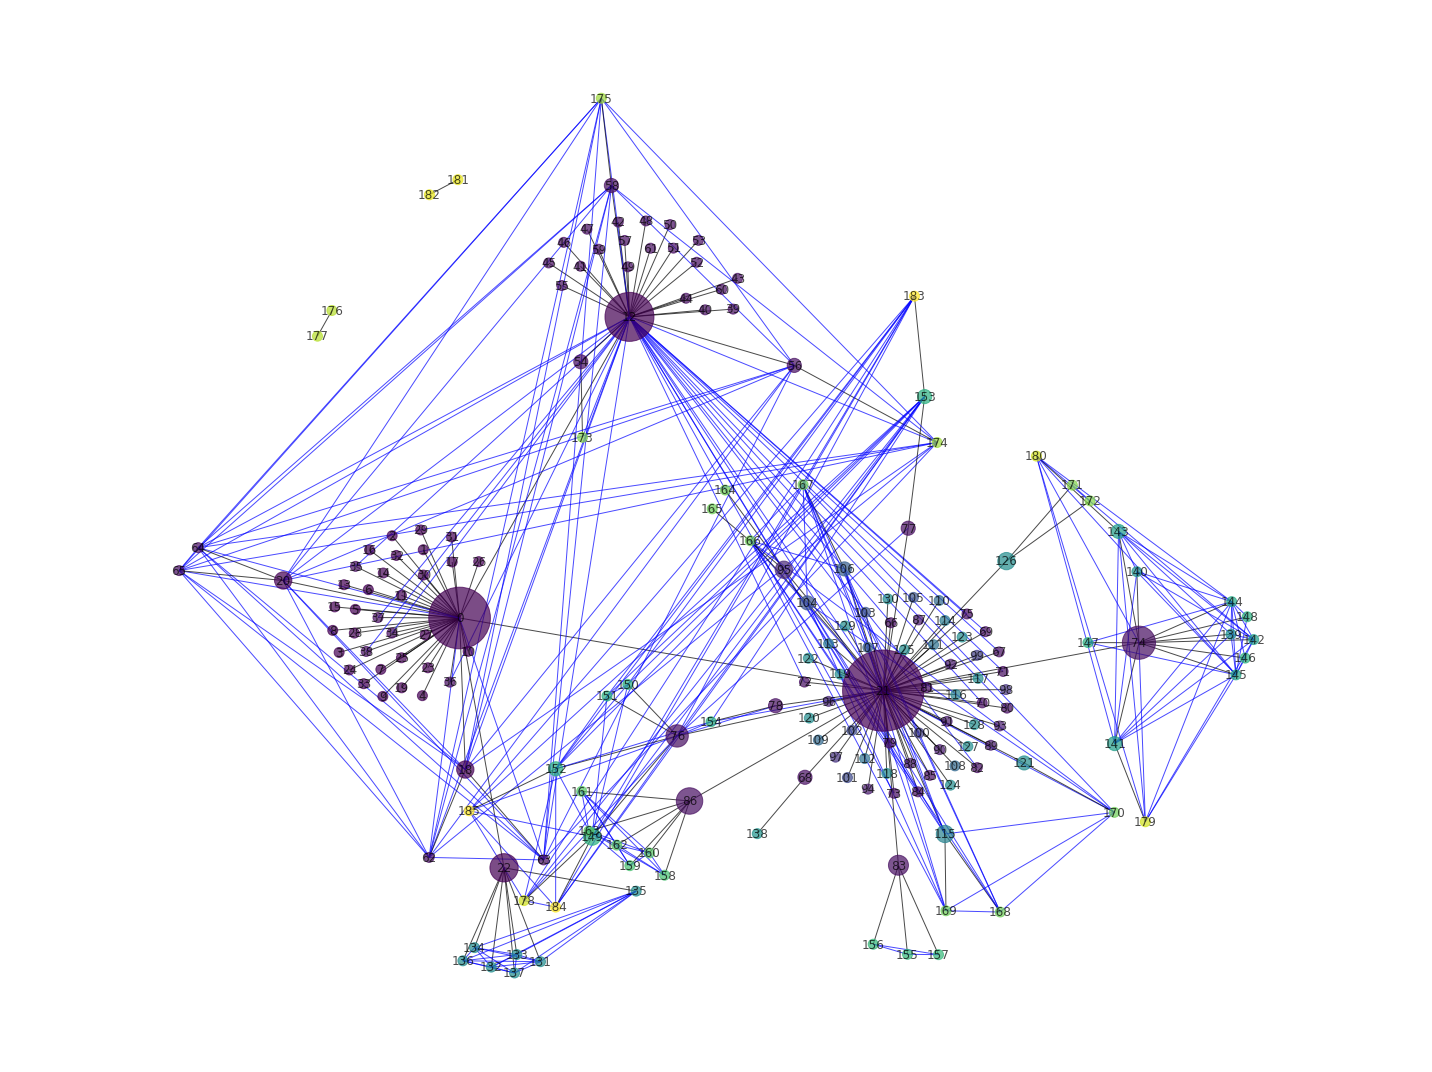

In [34]:
fig, ax = plt.subplots(figsize=(20, 15))

nx.draw_networkx(
    final_G,
    pos=pos,
    with_labels=True,
    node_color=node_color,
    node_size=node_size,
    edge_color=color,
    #edge_color="gainsboro",
    alpha=0.7,
)
# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()